# Import 

In [20]:
import os
import json
import tqdm
import random
import shutil
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import torchaudio
import torchaudio.transforms as T
from torchvision.models.resnet import ResNet, BasicBlock
import seaborn as sns
import matplotlib.pyplot as plt

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


# Data Loading

In [22]:
%cd /home/skang/Documents/kaggle/bird_clef/notebook
%pwd

/home/skang/Documents/kaggle/bird_clef/notebook


'/home/skang/Documents/kaggle/bird_clef/notebook'

In [23]:
root_path = "../input/birdclef-2022/"
input_path = root_path + '/train_audio/'
out_path = "./train/"

try:
    os.mkdir(out_path)
except FileExistsError:
    pass


train_meta = pd.read_csv(root_path + 'train_metadata.csv')

with open(root_path + '/scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [24]:
train_meta = train_meta[train_meta['primary_label'].isin(scored_birds)]
bird_label = train_meta["primary_label"].unique()
print(bird_label)

['akiapo' 'aniani' 'apapan' 'barpet' 'crehon' 'elepai' 'ercfra' 'hawama'
 'hawcre' 'hawgoo' 'hawhaw' 'hawpet1' 'houfin' 'iiwi' 'jabwar' 'maupar'
 'omao' 'puaioh' 'skylar' 'warwhe1' 'yefcan']


## Utils

In [25]:
sample_rate = 32000
n_fft = 4096
win_length = None
hop_length = 512
n_mels = 256
min_sec_proc = sample_rate*5
f_min = 1000
f_max = 16000 

mel_spectrogram = T.MelSpectrogram(
    sample_rate=sample_rate,
    n_fft=n_fft,
    win_length=win_length,
    hop_length=hop_length,
    f_min=f_min,
    f_max=f_max,
    power=2.0,
    n_mels=n_mels,
)

In [26]:
def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.use_deterministic_algorithms = True
    

def normalize_std(spec):
    return (spec- torch.mean(spec))/torch.std(spec)


def audio_to_mel_label(filepath, min_sec_proc, mode='train', data_index=0, label_list=[], bird_label=[], label_file=[], mel_list=[]):
    if mode == 'train':
        label_file_all = np.zeros(bird_label.shape)
        for label_file_temp in label_file:
            label_file_all += (label_file_temp == bird_label) # 배경에 포함되어 있는 새의 소리 중 중요 레이블에 포함된다면 그 또한 포함.
        label_file_all = np.clip(label_file_all, 0, 1)
    
    waveform, sample_rate_file = torchaudio.load(filepath=filepath)
    len_wav = waveform.shape[1]
    waveform = waveform[0,:].reshape(1, len_wav) # stereo->mono mono->mono
    if mode == 'train':
        if len_wav < min_sec_proc:
            for _ in range(round(min_sec_proc/len_wav)):
                waveform = torch.cat((waveform,waveform[:,0:len_wav]),1)# 부족한 부분을 0이 아니라 시작을 반복하게 설정
            len_wav = min_sec_proc
            waveform = waveform[:,0:len_wav]
    elif mode == 'test':
        if not len_wav < min_sec_proc*12:
            waveform = torch.cat((waveform,waveform[:,0:len_wav]),1)
            len_wav = min_sec_proc*12
            waveform = waveform[:,0:len_wav]

    for index in range(int(len_wav/min_sec_proc)):
        log_melspec = torch.log10(mel_spectrogram(waveform[0, index*min_sec_proc:index*min_sec_proc+min_sec_proc]).unsqueeze(0)+1e-10)
        log_melspec = normalize_std(log_melspec)
        if mode == 'train':
            torch.save(log_melspec, out_path + str(data_index) + '.pt')  # pt파일로 저장
            label_list.append(label_file_all)
            data_index += 1
        elif mode == 'test':
            mel_list.append(log_melspec) # 테스트 파일은 별도 저장 x 그냥 불러오기
            
    if mode == 'train':
        return data_index
    elif mode == 'test':
        return mel_list
    
    
def load_tensor(path, file_name):
    return torch.load(path + str(file_name) + '.pt')


def get_X_y(path, idx, label_list):
    batch_X = torch.stack([load_tensor(path, x.item()) for x in idx])
    batch_y = torch.stack([label_list[x.item()] for x in idx])
    return batch_X, batch_y


def plot_history(history):
    plt.figure(figsize=(10, 10)) 
    plt.plot(history[:,0], history[:,1], label='loss')
    plt.plot(history[:,0], history[:,2], label='val_loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
    
    
def show_heatmap(df):
    # make heatmap
    heatmap = []

    for idx, row in df.iterrows():
        _, _, species, sec = row.row_id.split("_")
        if sec == "5":
            sec = "05"
        true_or_false = row.target
        heatmap.append([species,sec,true_or_false])
    
    heatmap = pd.DataFrame(heatmap, columns=["species", "sec", "True_or_False"])

    # show heamap
    fig,ax = plt.subplots(figsize=(10,5))
    cmap = sns.color_palette("Blues")
    heatmap = heatmap.pivot("species", "sec", "True_or_False")
    sns.heatmap(heatmap,ax=ax,linecolor='k',lw=1,cmap=cmap)
    plt.title("Prediction result in soundscape_453028782.ogg")
    plt.show()    
    
torch_fix_seed()

# Save melspectorgram

In [27]:
data_index = 0
label_list = []
for pri_label, secon_label, f_name in zip(tqdm.notebook.tqdm(train_meta['primary_label']), train_meta['secondary_labels'],train_meta['filename']):
    data_index = audio_to_mel_label(input_path+f_name, min_sec_proc,'train', data_index, label_list, bird_label, [pri_label] + eval(secon_label))

torch.save(np.stack(label_list), out_path + 'label_list.pt')
label_list = torch.from_numpy(np.stack(label_list)).clone()

  0%|          | 0/1266 [00:00<?, ?it/s]

/home/skang/.local/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: stft will require the return_complex parameter be explicitly  specified in a future PyTorch release. Use return_complex=False  to preserve the current behavior or return_complex=True to return  a complex output. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:653.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore
/home/skang/.local/lib/python3.8/site-packages/torch/functional.py:515: UserWarning: The function torch.rfft is deprecated and will be removed in a future PyTorch release. Use the new torch.fft module functions, instead, by importing torch.fft and calling torch.fft.fft or torch.fft.rfft. (Triggered internally at  /pytorch/aten/src/ATen/native/SpectralOps.cpp:590.)
  return _VF.stft(input, n_fft, hop_length, win_length, window,  # type: ignore


## Model

In [28]:
n_output = len(bird_label)

out_sigmoid = nn.Sigmoid()

class ResNetBird(ResNet):
    def __init__(self):
        super().__init__(BasicBlock, [1, 4, 6, 3], num_classes=n_output)

        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

        
net = ResNetBird().to(device)

In [29]:
transforms = torch.nn.Sequential(
    torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
    torchaudio.transforms.TimeMasking(time_mask_param=20),
)
ComputeDeltas = torchaudio.transforms.ComputeDeltas(win_length= 5)

def time_shift(melspec):
    for i in range(melspec.shape[0]):
        ii = int(np.random.randint(melspec.shape[3]/4, melspec.shape[3]/(4/3), (1)))
        melspec[i,:,:,:] = torch.cat((melspec[i,:,:,ii:-1], melspec[i,:,:,0:ii+1]),2)
    
    return melspec

## Data split

In [30]:
train_idx = np.arange(0, label_list.shape[0])

data_len = train_idx.shape[0]
train_idx, val_idx = torch.utils.data.random_split(train_idx, [int(data_len*0.8), data_len-int(data_len*0.8)])

# Train loop

In [31]:
num_epochs = 50
lr = 0.001
batch_size = 16

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(net.parameters(), lr=lr)
history = np.zeros((0, 3))

train_loader = DataLoader(train_idx, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_idx, batch_size=batch_size, shuffle=False)

Epoch [1/50], loss: 0.12583, val_loss: 0.15158
Epoch [2/50], loss: 0.09577, val_loss: 0.09920
Epoch [3/50], loss: 0.08113, val_loss: 0.06643
Epoch [4/50], loss: 0.07101, val_loss: 0.06185
Epoch [5/50], loss: 0.06270, val_loss: 0.05434
Epoch [6/50], loss: 0.05604, val_loss: 0.04670
Epoch [7/50], loss: 0.05005, val_loss: 0.05163
Epoch [8/50], loss: 0.04510, val_loss: 0.04979
Epoch [9/50], loss: 0.04135, val_loss: 0.04586
Epoch [10/50], loss: 0.03680, val_loss: 0.03601
Epoch [11/50], loss: 0.03304, val_loss: 0.03404
Epoch [12/50], loss: 0.02941, val_loss: 0.03569
Epoch [13/50], loss: 0.02448, val_loss: 0.03317
Epoch [14/50], loss: 0.02216, val_loss: 0.02840
Epoch [15/50], loss: 0.01959, val_loss: 0.02682
Epoch [16/50], loss: 0.01613, val_loss: 0.02819
Epoch [17/50], loss: 0.01351, val_loss: 0.02678
Epoch [18/50], loss: 0.01233, val_loss: 0.02544
Epoch [19/50], loss: 0.01096, val_loss: 0.02412
Epoch [20/50], loss: 0.00943, val_loss: 0.03024
Epoch [21/50], loss: 0.00714, val_loss: 0.03338
E

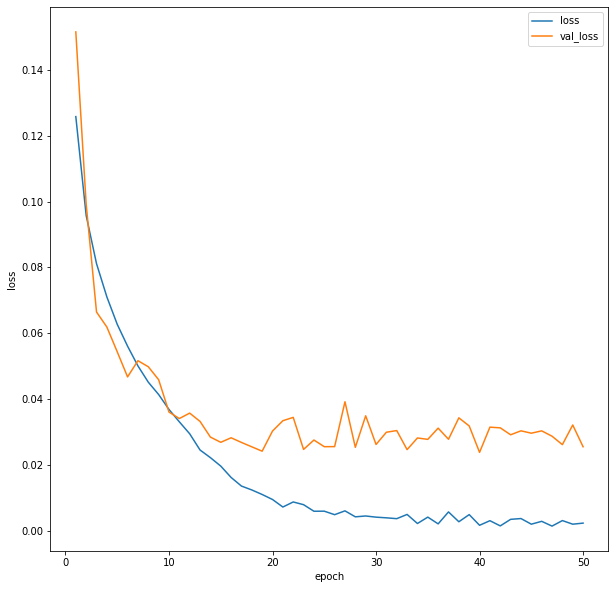

In [32]:
for epoch in range(num_epochs):
    train_loss, val_loss = 0, 0
    n_train, n_val = 0, 0

    net.train()
    for idx in train_loader:
        inputs, labels = get_X_y(out_path, idx, label_list)
        
        n_train += len(labels)
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    net.eval()
    with torch.no_grad():
        for idx in val_loader:
            inputs_val, labels_val = get_X_y(out_path, idx, label_list)
            n_val += len(labels)

            inputs_val = inputs_val.to(device)
            labels_val = labels_val.to(device)

            outputs_val = net(inputs_val)

            loss_val = criterion(outputs_val, labels_val)

            val_loss += loss_val.item()
    

    train_loss = train_loss * batch_size / n_train
    val_loss = val_loss * batch_size / n_val
    print (f'Epoch [{(epoch+1)}/{num_epochs}], loss: {train_loss:.5f}, val_loss: {val_loss:.5f}')
    item = np.array([epoch+1, train_loss, val_loss])
    history = np.vstack((history, item))

torch.save(net.state_dict(), 'model.pt')
plot_history(history)

# Inference

In [33]:
test_audio_dir = '../input/birdclef-2022/test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(test_audio_dir))]

print('Number of test soundscapes:', len(file_list))

Number of test soundscapes: 1


In [34]:
pred = {'row_id': [], 'target': []}
binary_th = 0.30
net.eval()

for afile in file_list:
    
    path = test_audio_dir + afile + '.ogg'
    
    chunks = [[] for i in range(12)]
    
    mel_list_test = []
    mel_list_test = audio_to_mel_label(path, min_sec_proc,'test', mel_list=mel_list_test)
    mel_list_test = torch.stack(mel_list_test).to(device)
    
    outputs = net(mel_list_test)
    
    outputs_test = out_sigmoid(outputs)
    
    for idx, i in enumerate(range(len(chunks))):        
        chunk_end_time = (i + 1) * 5
        for bird in scored_birds:
            
            try:
                score = outputs_test[idx][np.where(bird_label==bird)]
            except IndexError:
                score = 0
            
            row_id = afile + '_' + bird + '_' + str(chunk_end_time)
            
            pred['row_id'].append(row_id)
            pred['target'].append(True if score > binary_th else False)

# Submission

In [35]:
results = pd.DataFrame(pred, columns = ['row_id', 'target'])

print(results['target']) 
    
results.to_csv("submission.csv", index=False)   

0      False
1      False
2      False
3      False
4      False
       ...  
247    False
248    False
249     True
250    False
251    False
Name: target, Length: 252, dtype: bool


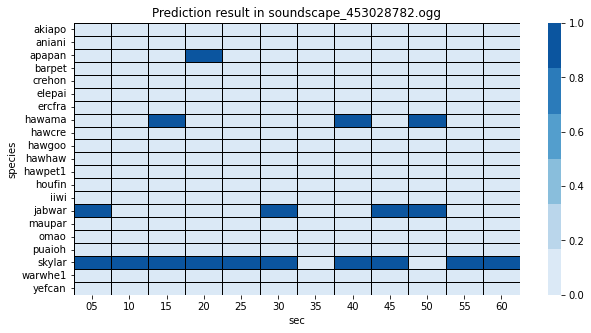

In [36]:
show_heatmap(results)